<a href="https://colab.research.google.com/github/fuat-arslan/Pytorch_Scratch/blob/main/CV/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Written by Fuat Arslan

This is the in complete version. But meets basic requirements.


Original paper of ResNet can be found as [ResNet Paper](https://arxiv.org/pdf/1512.03385.pdf?ref=blog.paperspace.com)

Idea is to using skip connection avoidng gradient vanishing problem. This allow it to use deeper models.

By their original workds "Deeper neural networks are more difficult to train. We
present a residual learning framework to ease the training
of networks that are substantially deeper than those used
previously. We explicitly reformulate the layers as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions."

In [88]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms

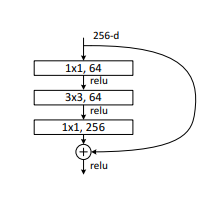

In [175]:
class BottleNeck(nn.Module):
    """
    Intermediate dimension can be determined by chose but first and last is
    designed as described in the paper.
    """
    def __init__(self, in_channels, expansion_dim, connection_method=None, stride=1):
        super().__init__()


        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, expansion_dim, kernel_size=1, stride=1, padding=0,bias=False),
            nn.BatchNorm2d(expansion_dim),
            nn.ReLU()
            )

        self.block2 = nn.Sequential(
            nn.Conv2d(expansion_dim, expansion_dim, kernel_size=3, stride = stride, padding=1, bias=False),
            nn.BatchNorm2d(expansion_dim),
            nn.ReLU()
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(expansion_dim,expansion_dim*4, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(expansion_dim*4),
            nn.ReLU()
        )

        self.connection_method = connection_method

    def forward(self, x):

        # print("Entered BottleNeck")
        res = x.clone()
        # print(x.shape)
        x = self.block1(x)
        # print(x.shape)
        x = self.block2(x)
        # print(x.shape)
        x = self.block3(x)
        # print(x.shape)

        if self.connection_method:
            res = self.connection_method(res)

        x += res
        x = nn.ReLU()(x)

        return x



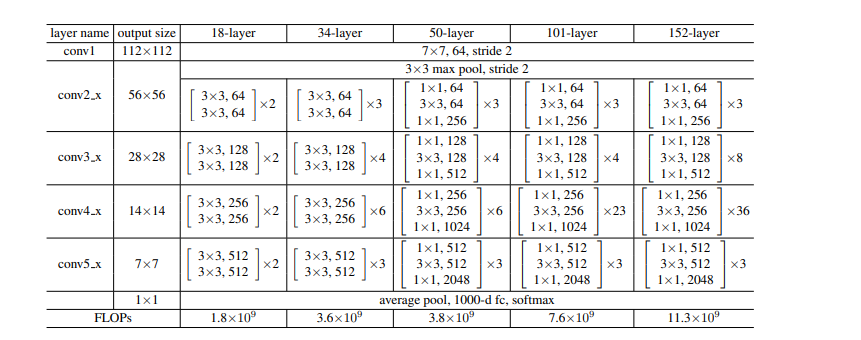

In [176]:
class ResNet(nn.Module):
    def __init__(self, bottleneck, layers, img_channels, n_class):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.depth = len(layers)

        for i in range(len(layers)):

            temp = self.block_generator(bottleneck, layers[i])
            setattr(self, f'conv{i+1}_x', temp)

        self.averagepool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*4, n_class)


    def block_generator(self, block,block_info ):
        num_block, expansion_dim, stride = block_info
        layers = []

        connection_method = None

        if stride !=1 or expansion_dim*4 != self.in_channels:
            connection_method = nn.Sequential(
                nn.Conv2d(self.in_channels, expansion_dim*4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(expansion_dim*4)
            )

        layers.append(block(self.in_channels, expansion_dim,connection_method,stride))
        self.in_channels = expansion_dim*4

        for i in range(num_block-1):
            layers.append(block(expansion_dim*4,expansion_dim))

        return nn.Sequential(*layers)

    def forward(self,x):

        x = self.conv1(x)
        # print(x.shape)

        for i in range(self.depth):
            block_name = f'conv{i+1}_x'
            block_ = getattr(self, block_name)
            # print(x)
            # print(type(block_))
            x = block_(x)
            # print(x)
            # print(x.shape)

        x = self.averagepool(x)
        x = x.reshape(x.shape[0],-1)
        x = self.fc(x)

        return x




In [181]:
def ResNet50(img_channels=3,n_class=1000):
    return ResNet(BottleNeck,[(3,64,1),(4,128,2),(6,256,2),(3,512,2)], img_channels, n_class)

def ResNet101(img_channels=3,n_class=1000):
    return ResNet(BottleNeck,[(3,64,1),(4,128,2),(23,256,2),(3,512,2)], img_channels, n_class)

def ResNet152(img_channels=3,n_class=1000):
    return ResNet(BottleNeck,[(3,64,1),(8,128,2),(36,256,2),(3,512,2)], img_channels, n_class)

In [183]:
net = ResNet152()

In [184]:
print(net)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv1_x): Sequential(
    (0): BottleNeck(
      (block1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (block2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (block3): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_ru

In [187]:
#Quick Test
BATCH_SIZE = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = ResNet152().to(device)
y = net(torch.randn(BATCH_SIZE, 3, 224, 224)).to(device)
assert y.size() == torch.Size([BATCH_SIZE, 1000])
print(y.size())


torch.Size([4, 64, 56, 56])
torch.Size([4, 1000])
